# HW #4: Writing a code for predicting TF binding sites   

student ID: 22100748   
student name: Yunyoung Choi

  
  
Make your own programs called “MakePWM” and “FindMotifs” to predict the TF binding site candidate(s) in the given DNA sequence.   
  
“MakePWM” should   
1) convert PSCM (Position-specific count matrix) to PWM (Position weight matrix) with the given background probabilities (-bg option) and pseudo-count (-k option), and   
2) generate sequence logo images for them (.png format).    
    
      
“FindMotifs”   
1) scans the given DNA sequence with the PWM, and   
2) returns the TF binding site candidates and their information such as positions, PWM scores (see the example below). The key algorithms required for the alignments are written (in a pseudo-code format) in the uploaded lecture slides.   
Make the two input files - PSCM.fasta (fasta format + .csv format) and enhancer.txt using the uploaded files before programming your code.

# 1. MakePWM

In [ ]:
!pip install biopython logomaker

In [ ]:
# import required libraries
import pandas as pd
import numpy as np
import logomaker
import os
import matplotlib.pyplot as plt
import warnings

In [ ]:
# set parameters
input_file_path = '/content/drive/MyDrive/Bioinformatics/HW#4/PSCM.fasta'
output_dir = "/content/drive/MyDrive/Bioinformatics/HW#4"
gc_content = 0.409
pseudo_count = 0.25

In [ ]:
'''
func 1: parse_fasta

input parameter: input file path

Description:
- read fasta format file
- and parse it into dataframe.

returns:
- sequences(list; multiple dataframes) pscm and
- sequence names (such as OCT4_1, OCT4_2, etc)

'''

def parse_fasta(file_path):
    # Initialize a list to store sequence DataFrames and names
    sequences = []
    sequence_names = []
    current_dict = {}
    current_name = None

    # Open the FASTA file and read it line by line
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace

            # Skip empty lines
            if not line:
                continue

            # Check if the line is a header line (starts with '>')
            if line.startswith('>'):
                # Save the current sequence (if any) before starting a new one
                if current_dict:
                    sequences.append(pd.DataFrame(current_dict))
                    sequence_names.append(current_name)
                    current_dict = {}  # Reset for the next sequence

                # Extract the sequence name (remove '>' and take the rest of the line)
                current_name = line[1:].strip()
            else:
                # Split the line into base and values
                parts = line.split()
                base = parts[0]
                values = list(map(int, parts[1:]))
                current_dict[base] = values

        # After the last sequence, save the remaining dictionary
        if current_dict:
            sequences.append(pd.DataFrame(current_dict))
            sequence_names.append(current_name)

    # Return both sequences and their corresponding names
    return sequences, sequence_names

In [ ]:
'''
func 2: pscm to pwm

input parameters: pscm_list, gc_content, pseudo_count

Description:
- make pwm dataframes from pscm matrix.

returns:
- pwm_list(list; multiple dataframes)

'''

def pscm_to_pwm(pscm_list, gc_content=0.6, pseudo_count=0.25):
    bg_gc = gc_content / 2  # G and C share the GC percentage
    bg_at = (1 - gc_content) / 2  # A and T share the remaining percentage
    background_probs = {'A': bg_at, 'C': bg_gc, 'G': bg_gc, 'T': bg_at}

    pwm_list = []  # List to store PWM DataFrames

    # Loop over each PSCM DataFrame in the list
    for pscm_df in pscm_list:
        pwm_df = pd.DataFrame(index=pscm_df.index, columns=pscm_df.columns)  # Initialize PWM DataFrame

        # Loop over each position in the DataFrame
        for pos in pscm_df.index:
            # Total count at this position (sum across all bases)
            total_count = pscm_df.loc[pos].sum() + pseudo_count * len(pscm_df.columns)

            # Calculate PWM values for each base
            for base in pscm_df.columns:
                count = pscm_df.loc[pos, base] + pseudo_count  # Add pseudo-count
                freq = count / total_count  # Convert count to frequency
                bg_prob = background_probs[base]  # Get background probability
                pwm_value = np.log(freq / bg_prob)  # Calculate log-odds ratio
                pwm_df.loc[pos, base] = pwm_value

        pwm_list.append(pwm_df)  # Append the PWM DataFrame to the result list

    return pwm_list


In [ ]:
'''
func 3: save pwm to fasta

input parameters: pscm_list, sequence_names, output_dir

Description:
- save pwm dataframe into fasta file format

returns:
- save fasta files into output directory

'''


def save_pwm_to_fasta(pwm_list, sequence_names, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    for pwm, name in zip(pwm_list, sequence_names):
        # Generate the file path
        file_path = os.path.join(output_dir, f"{name}.fasta")

        # Write the PWM to a FASTA file
        with open(file_path, "w") as file:
            # Write the sequence header
            file.write(f">{name}\n")

            # Write each base row as a FASTA-compatible line
            for base in pwm.columns:  # Iterate over columns: A, C, G, T
                values = pwm[base].tolist()  # Get the values as a list
                values_string = " ".join(f"{value:.6f}" for value in values)  # Format values
                file.write(f"{base} {values_string}\n")  # Write the base and values


In [ ]:
'''
func 4: save sequence logos

input parameters: pscm_list, sequence_names, output_dir

Description:
- save pwm dataframe into fasta file format

returns:
- save fasta files into output directory

'''

def save_sequence_logos(pscm_list, sequence_names, output_dir):
    warnings.simplefilter("ignore", category=FutureWarning)
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    for pwm, name in zip(pscm_list, sequence_names):
        # Transform the PWM to information matrix
        info_matrix = logomaker.transform_matrix(
            pwm,
            from_type='probability',
            to_type='information'
        )

        # Create a sequence logo
        logo = logomaker.Logo(info_matrix, color_scheme='classic')

        # Customize the logo (optional)
        logo.style_spines(visible=False)  # Hide spines
        logo.ax.set_xticks(range(len(pwm)))  # Set x-axis ticks
        logo.ax.set_xlabel('Position')  # Label x-axis
        logo.ax.set_ylabel('Information (bits)')  # Label y-axis

        # Save the sequence logo as a PNG file
        file_name = f"{name}_SeqLogo.png"
        file_path = os.path.join(output_dir, file_name)
        logo.fig.savefig(file_path, format='png', dpi=300)
        logo.fig.clf()  # Clear the figure for the next logo

        plt.figure(figsize=(8, 4))
        plt.imshow(logo.fig.canvas.renderer.buffer_rgba())  # Display the figure
        plt.axis('off')  # Hide axes
        plt.title(f"{name} Sequence Logo")  # Display file name as title
        plt.show()  # Show the sequence logo

    print(f"Successfully generated {len(pscm_list)} PWMs and their sequence logos. "
          f"Please check the folder \"{output_dir}\".")

In [ ]:
'''
predefined parameters:

input_file_path = '/content/drive/MyDrive/Bioinformatics/HW#4/PSCM.fasta'
output_dir = "/content/drive/MyDrive/Bioinformatics/HW#4"
gc_content = 0.409  (40.9%)
pseudo_count = 0.25
'''

# concat all the previous functions with input parameters
def MakePWM(input_file_path, gc_content, pseudo_count, output_dir):
    sequences, sequence_names = parse_fasta(input_file_path)
    pwm_list = pscm_to_pwm(sequences, gc_content=gc_content, pseudo_count=pseudo_count)
    save_sequence_logos(sequences, sequence_names, output_dir)
    save_pwm_to_fasta(pwm_list, sequence_names, output_dir)

    return sequences, sequence_names, pwm_list

in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...


<Figure size 1000x250 with 0 Axes>

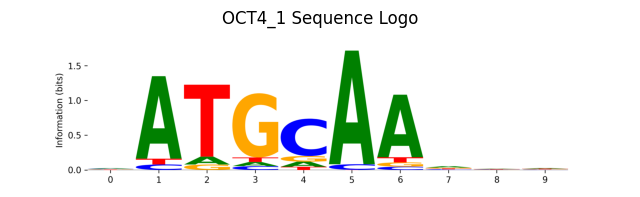

in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...


<Figure size 1000x250 with 0 Axes>

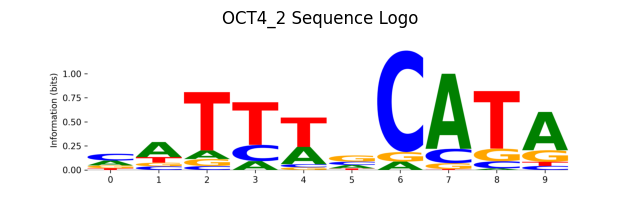

Successfully generated 2 PWMs and their sequence logos. Please check the folder "/content/drive/MyDrive/Bioinformatics/HW#4".


In [ ]:
# execute!
pscms, pscm_names, pwm_list = MakePWM(input_file_path, gc_content, pseudo_count, output_dir)

# 2. FindMotifs

In [ ]:
input_enhancer_path = "/content/drive/MyDrive/Bioinformatics/HW#4/enhancer.txt"

In [ ]:
def read_enhancer(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Skip the header line and join all the sequence lines into a single string
    sequence = ''.join(line.strip() for line in lines[1:])  # Exclude the first line (header)

    return sequence

In [ ]:
def calculate_pwm_score(sequence, pwm):
    score = 0.0
    for i, base in enumerate(sequence):
        if base not in pwm.columns:
            continue  # Skip bases not in the PWM (for example, if the sequence contains 'N')
        score += pwm.at[i, base]

    return score

In [ ]:
def find_motifs(enhancer_sequence, pwm_list, pscm_names, pwm_name, threshold=0.5):
    if pwm_name not in pscm_names:
        print(f"Error: PWM with name '{pwm_name}' not found.")
        return

    pwm_index = pscm_names.index(pwm_name)
    pwm = pwm_list[pwm_index]

    # Get the length of the PWM, which will be the size of the sliding window
    window_size = len(pwm)

    # Initialize variables to track the scores and binding sites
    scores = []
    highest_score = -float('inf')
    highest_score_position = -1

    # Sliding window: Calculate PWM scores for each window in the enhancer sequence
    for i in range(len(enhancer_sequence) - window_size + 1):
        window = enhancer_sequence[i:i + window_size]  # Extract the window sequence
        score = calculate_pwm_score(window, pwm)  # Calculate the PWM score for this window
        scores.append(score)

        # Update highest score and position if needed
        if score > highest_score:
            highest_score = score
            highest_score_position = i

    # Print the result in the desired format
    print(f"TF name: OCT4")
    print(f"Position weight matrix name: {pwm_name}")
    print(f"Threshold: {threshold}")

    # Find binding sites based on the threshold
    binding_sites = []
    for i, score in enumerate(scores):
        if score >= threshold:
            # Extract the sequence of the binding site from the enhancer sequence
            binding_site_sequence = enhancer_sequence[i:i + window_size]
            binding_sites.append((i, binding_site_sequence, score))

    print(f"No. sites: {len(binding_sites)}")
    print(f"Highest PWM score: {highest_score}")
    print(f"Highest score binding site: {enhancer_sequence[highest_score_position:highest_score_position + window_size]}")

    # Print binding sites
    for idx, (start, site, score) in enumerate(binding_sites, 1):
        end = start + window_size - 1
        print(f"{idx}: {site} | {start+1},{end+1} | {score:.3f}")


In [ ]:
enhancer_sequence = read_enhancer(input_enhancer_path)
pwm_name = "OCT4_1"
find_motifs(enhancer_sequence, pwm_list, pscm_names, pwm_name, threshold = 0.5)

TF name: OCT4
Position weight matrix name: OCT4_1
Threshold: 0.5
No. sites: 9
Highest PWM score: 4.974331999787497
Highest score binding site: CATGGAACTT
1: CATGGAACTT | 36,45 | 4.974
2: ACTCCAACAA | 46,55 | 1.913
3: AATACAGATG | 54,63 | 1.835
4: AATGTAGTCT | 71,80 | 1.766
5: GAAGGAAGAA | 85,94 | 3.213
6: GAAGGAAAGG | 92,101 | 3.160
7: AAGGAAAGGT | 93,102 | 2.591
8: GCTGCCATCA | 107,116 | 2.053
9: CCAGCAGGGA | 128,137 | 0.542


In [ ]:
pwm_name = "OCT4_2"
find_motifs(enhancer_sequence, pwm_list, pscm_names, pwm_name, threshold = 0.5)

TF name: OCT4
Position weight matrix name: OCT4_2
Threshold: 0.5
No. sites: 7
Highest PWM score: 5.232812824100782
Highest score binding site: TATTAACATA
1: TATTAACATA | 6,15 | 5.233
2: TATTAACATG | 30,39 | 4.416
3: ACAATACAGA | 52,61 | 1.105
4: ATGCTGAATA | 61,70 | 1.600
5: ACTCAGAATT | 116,125 | 0.534
6: GTCCAGCAGG | 126,135 | 1.192
7: AATAAAGACA | 153,162 | 0.622


# Result Explanation

- Test which PMM (among OCT4_1 and OCT4_2) finds the OCT4 binding sites located in the enhancer sequence more accurately.

    TF binding site sequence 1: ATTAACAT  
    TF binding site sequence 2: ATTAACAT

    In the OCT4_1 PWM, the exact TF binding sites could not be identified, whereas in the OCT4_2 PWM, the binding sites were accurately detected. It is evident that accurate binding site sequences were found in indices 1, 2, and 4 of OCT4_2.


- Explain why they show the different performances.  
    
    OCT4_1 and OCT4_2 may be generated using different experimental methods. The quality of a PWM depends on how much information content it contains. Based on the results, OCT4_2, which identifies more precise binding sites, can be concluded to be the better PWM.

